In [70]:
# Uncomment to run the notebook in Colab
# ! pip install -q "wax-ml[complete]@git+https://github.com/eserie/wax-ml.git"
# ! pip install -q --upgrade jax jaxlib==0.1.70+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
# check available devices
import jax

In [ ]:
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
jax.devices()

# 🔭 Reconstructing the light curve of stars with LSTM 🔭

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eserie/wax-ml/blob/main/docs/notebooks/05_reconstructing_the_light_curve_of_stars.ipynb)

Let's take a walk through the stars...

This notebook is based on the study done in
[this post by Christophe Pere](https://towardsdatascience.com/how-to-use-deep-learning-for-time-series-forecasting-3f8a399cf205)
and the notebook available on
[the authors's github](https://github.com/Christophe-pere/Time_series_RNN).

We will repeat this study on starlight using the LSTM architecture to predict the observed light flux through time.

Our LSTM implementation is based on this [notebook from Haiku's github repository](https://github.com/deepmind/dm-haiku/blob/master/examples/haiku_lstms.ipynb).

We'll see how to use WAX-ML to ease the preparation of time series data stored in dataframes and having Nans
before calling a "standard" deep-learning workflow.

## Disclaimer

Despite the fact that this code works with real data, the results presented here should not be considered as scientific knowledge insights, to the knowledge of the authors of WAX-ML, neither the results nor the data source have been reviewed by an astrophysics pair.

The purpose of this notebook is only to demonstrate how WAX-ML can be used when applying a "standard" machine learning workflow, here LSTM, to analyze time series.

## Download the data

In [1]:
%matplotlib inline

In [2]:
import io
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

from wax.accessors import register_wax_accessors
from wax.modules import RollingMean

register_wax_accessors()

In [5]:
# Parameters
STAR = "007609553"
SEQ_LEN = 64
BATCH_SIZE = 8
TRAIN_STEPS = 2 ** 16
TRAIN_SIZE = 2 ** 16
TOTAL_LEN = None
TRAIN_DATE = "2016"
CACHE_DIR = Path("./cached_data/")

In [6]:
%%time
filename = CACHE_DIR / "kep_lightcurves.parquet"
try:
    raw_dataframe = pd.read_parquet(open(filename, "rb"))
    print(f"data read from {filename}")
except FileNotFoundError:
    # Downloading the csv file from Chrustioge Pere GitHub account
    download = requests.get(
        "https://raw.github.com/Christophe-pere/Time_series_RNN/master/kep_lightcurves.csv"
    ).content
    raw_dataframe = pd.read_csv(io.StringIO(download.decode("utf-8")))
    # set date index
    raw_dataframe.index = pd.Index(
        pd.date_range("2009-03-07", periods=len(raw_dataframe.index), freq="h"),
        name="time",
    )
    # save dataframe locally in CACHE_DIR
    CACHE_DIR.mkdir(exist_ok=True)
    raw_dataframe.to_parquet(filename)
    print(f"data saved in {filename}")

data saved in cached_data/kep_lightcurves.parquet
CPU times: user 1.2 s, sys: 197 ms, total: 1.39 s
Wall time: 3.73 s


In [7]:
# shortening of data to speed up the execution of the notebook in the CI
if TOTAL_LEN:
    raw_dataframe = raw_dataframe.iloc[:TOTAL_LEN]

Let's visualize the description of this dataset:

In [8]:
raw_dataframe.describe().T.to_xarray()

<xarray.Dataset>
Dimensions:  (index: 52)
Coordinates:
  * index    (index) object '001430305_orig' ... '011611275_res'
Data variables:
    count    (index) float64 6.48e+04 5.674e+04 ... 5.673e+04 5.673e+04
    mean     (index) float64 6.776e+04 -0.2265 0.01231 ... 0.001437 0.004351
    std      (index) float64 1.363e+03 15.42 15.27 12.45 ... 4.648 6.415 4.904
    min      (index) float64 6.529e+04 -123.3 -75.59 ... -20.32 -31.97 -20.89
    25%      (index) float64 6.619e+04 -9.488 -9.875 ... -3.269 -4.281 -3.279
    50%      (index) float64 6.806e+04 -0.3476 0.007812 ... 0.007812 -0.06529
    75%      (index) float64 6.882e+04 8.988 10.02 8.092 ... 2.872 4.277 3.213
    max      (index) float64 7.021e+04 128.7 72.31 69.34 ... 26.53 30.94 29.45

In [9]:
stars = raw_dataframe.columns
stars = sorted(list(set([i.split("_")[0] for i in stars])))
print(f"The number of stars available is: {len(stars)}")
print(f"star identifiers: {stars}")

The number of stars available is: 13
star identifiers: ['001430305', '001724719', '005209845', '007596240', '007609553', '008241079', '008247770', '009345933', '009347009', '009349482', '009349757', '010024701', '011611275']


In [10]:
dataframe = raw_dataframe[[i + "_rscl" for i in stars]].rename(
    columns=lambda c: c.replace("_rscl", "")
)
dataframe.columns.names = ["star"]
dataframe.shape

(71427, 13)

## Rolling mean

We will smooth the data by applying a rolling mean with a window of 100 periods.

### Count nan values

But before since the dataset has some nan values, we will extract few statistics
about the density of nan values in windows of size 100.

It will be the occasion to show a usage of the `wax.modules.Buffer` module with the `format_outputs=False`
option for the dataframe accessor `.wax.stream`.

In [11]:
import jax.numpy as jnp
import numpy as onp

In [12]:
from wax.modules import Buffer

Let's apply the `Buffer` module to the data:

In [13]:
buffer, _ = dataframe.wax.stream(format_outputs=False).apply(lambda x: Buffer(100)(x))

In [14]:
assert isinstance(buffer, jnp.ndarray)

Let's describe the statistic of nans with pandas:

In [15]:
count_nan = jnp.isnan(buffer).sum(axis=1)
pd.DataFrame(onp.array(count_nan)).stack().describe().astype(int)

count    928551
mean         20
std          27
min           0
25%           5
50%           8
75%          19
max         100
dtype: int64

### Computing the rolling mean

We will choose a `min_periods` of 5 in order to keep at leas 75% of the points.

In [16]:
%%time
dataframe_mean, _ = dataframe.wax.stream().apply(
    lambda x: RollingMean(100, min_periods=5)(x)
)

CPU times: user 446 ms, sys: 11.5 ms, total: 458 ms
Wall time: 456 ms


<AxesSubplot:xlabel='time'>

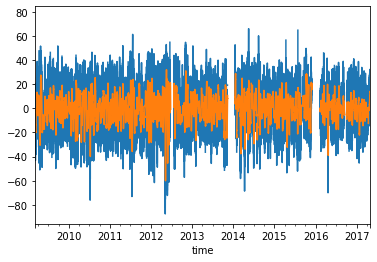

In [17]:
dataframe.loc[:, "008241079"].plot()
dataframe_mean.loc[:, "008241079"].plot()

### With Dataset API

Let's illustrate how to do the same rolling mean operation but using wax accessors on xarray `Dataset`.

In [18]:
from functools import partial

from jax.tree_util import tree_map

In [19]:
dataset = dataframe.to_xarray()

In [20]:
dataset

<xarray.Dataset>
Dimensions:    (time: 71427)
Coordinates:
  * time       (time) datetime64[ns] 2009-03-07 ... 2017-04-30T02:00:00
Data variables: (12/13)
    001430305  (time) float64 -4.943 2.338 nan -0.9275 ... 13.92 7.728 nan 1.33
    001724719  (time) float64 -9.95 -19.69 -6.298 nan ... 7.535 nan 0.8825
    005209845  (time) float64 nan nan nan nan ... -5.528 -6.864 -25.47 -25.75
    007596240  (time) float64 -1.353 -1.534 -9.497 -3.48 ... 4.234 -3.83 -0.6448
    007609553  (time) float64 38.36 19.7 19.08 27.18 ... 172.2 178.2 163.8 169.9
    008241079  (time) float64 -22.68 -12.27 nan -10.34 ... 3.236 8.97 18.74
    ...         ...
    009345933  (time) float64 -9.756 -9.812 -8.808 ... 5.486 -10.21 -1.196
    009347009  (time) float64 2.219 -3.694 -3.056 -3.843 ... -3.58 11.99 -1.917
    009349482  (time) float64 -4.975 -11.5 -7.711 -9.017 ... 2.338 1.825 0.9793
    009349757  (time) float64 nan -16.64 -20.52 -15.6 ... nan 19.15 17.15 18.18
    010024701  (time) float64 -45.78 -54.53 -35.46 ... -292.7 -301.2 -283.9
    011611275  (time) float64 -1.308 -4.728 -5.136 2.284 ... 12.73 -6.223 -8.024

In [21]:
%%time
dataset_mean, _ = dataset.wax.stream().apply(
    partial(tree_map, lambda x: RollingMean(100, min_periods=5)(x)),
    format_dims=["time"],
)

CPU times: user 5.53 s, sys: 132 ms, total: 5.67 s
Wall time: 5.67 s


(Its much longer than with dataframe)

TODO: This is an issue that we should solve.

In [22]:
dataset_mean

<xarray.Dataset>
Dimensions:    (time: 71427)
Coordinates:
  * time       (time) datetime64[ns] 2009-03-07 ... 2017-04-30T02:00:00
Data variables: (12/13)
    001430305  (time) float32 nan nan nan nan ... -0.1169 0.1599 0.2577 0.3024
    001724719  (time) float32 nan nan nan nan ... -6.384 -6.214 -6.223 -6.147
    005209845  (time) float32 nan nan nan nan ... -9.909 -9.939 -10.13 -10.29
    007596240  (time) float32 nan nan nan nan nan ... 1.165 1.19 1.14 1.134
    007609553  (time) float32 nan nan nan nan 25.99 ... 145.5 146.0 146.4 146.9
    008241079  (time) float32 nan nan nan nan nan ... 13.57 13.57 13.4 13.47
    ...         ...
    009345933  (time) float32 nan nan nan nan ... -14.8 -14.53 -14.48 -14.31
    009347009  (time) float32 nan nan nan nan ... -3.367 -3.462 -3.263 -3.25
    009349482  (time) float32 nan nan nan nan -8.398 ... 1.861 1.858 1.817 1.825
    009349757  (time) float32 nan nan nan nan nan ... 10.3 10.61 10.91 11.08
    010024701  (time) float32 nan nan nan nan ... -322.8 -323.0 -322.8 -322.9
    011611275  (time) float32 nan nan nan nan ... -4.214 -4.037 -4.106 -4.192

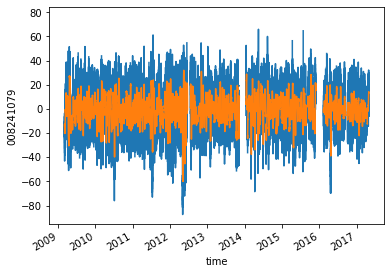

In [23]:
dataset["008241079"].plot()
dataset_mean["008241079"].plot()

### With dataarray

In [24]:
dataarray = dataframe.to_xarray().to_array("star").transpose("time", "star")

In [25]:
dataarray

<xarray.DataArray (time: 71427, star: 13)>
array([[  -4.94312846,   -9.94989465,           nan, ...,           nan,
         -45.78391029,   -1.30840132],
       [   2.33812154,  -19.6881759 ,           nan, ...,  -16.6422077 ,
         -54.53000404,   -4.7283232 ],
       [          nan,   -6.2975509 ,           nan, ...,  -20.52306708,
         -35.45969154,   -5.13554976],
       ...,
       [   7.7280167 ,    7.53484594,   -6.86435205, ...,   19.15124702,
        -292.7287725 ,   12.73319537],
       [          nan,           nan,  -25.47275049, ...,   17.15027046,
        -301.15455375,   -6.22285932],
       [   1.3295792 ,    0.88250219,  -25.74862939, ...,   18.18347358,
        -283.88111625,   -8.02364057]])
Coordinates:
  * time     (time) datetime64[ns] 2009-03-07 ... 2017-04-30T02:00:00
  * star     (star) <U9 '001430305' '001724719' ... '010024701' '011611275'

In [26]:
%%time
dataarray_mean, _ = dataarray.wax.stream().apply(
    lambda x: RollingMean(100, min_periods=5)(x)
)

CPU times: user 426 ms, sys: 7.23 ms, total: 433 ms
Wall time: 431 ms


(Its much longer than with dataframe)

In [27]:
dataarray_mean

<xarray.DataArray (time: 71427, star: 13)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [ 1.5992440e-01, -6.2136836e+00, -9.9386721e+00, ...,
         1.0611248e+01, -3.2304874e+02, -4.0370173e+00],
       [ 2.5768742e-01, -6.2231779e+00, -1.0134243e+01, ...,
         1.0905440e+01, -3.2282303e+02, -4.1056514e+00],
       [ 3.0240160e-01, -6.1467724e+00, -1.0286570e+01, ...,
         1.1077212e+01, -3.2285059e+02, -4.1921792e+00]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2009-03-07 ... 2017-04-30T02:00:00
  * star     (star) <U9 '001430305' '001724719' ... '010024701' '011611275'

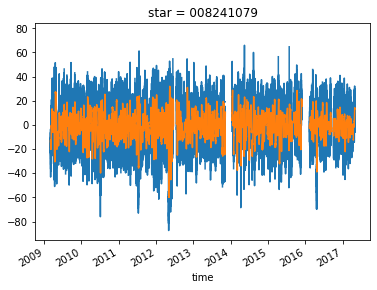

In [28]:
dataarray.sel(star="008241079").plot()
dataarray_mean.sel(star="008241079").plot()

## Forecasting with Machine Learning

We need two forecast in this data, if you look with attention you'll see micro holes and big holes.

In [29]:
import warnings
from typing import NamedTuple, Tuple, TypeVar

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
import plotnine as gg

T = TypeVar("T")
Pair = Tuple[T, T]


class Pair(NamedTuple):
    x: T
    y: T


class TrainSplit(NamedTuple):
    train: T
    validation: T


gg.theme_set(gg.theme_bw())
warnings.filterwarnings("ignore")

(0.0, 1.0, 0.0, 1.0)

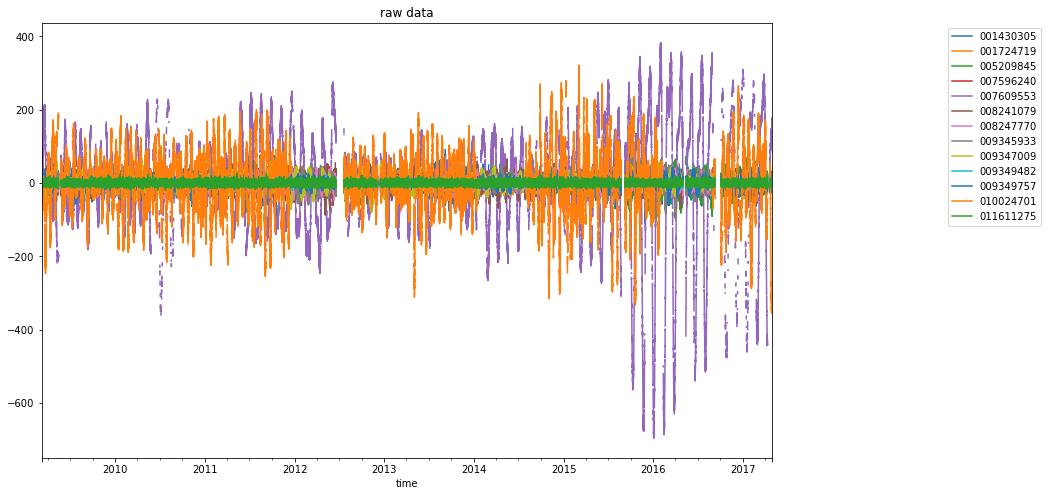

In [30]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 18, 8
fig, (ax, lax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [4, 1]})
dataframe.plot(ax=ax, title="raw data")
ax.legend(bbox_to_anchor=(0, 0, 1, 1), bbox_transform=lax.transAxes)
lax.axis("off")

(0.0, 1.0, 0.0, 1.0)

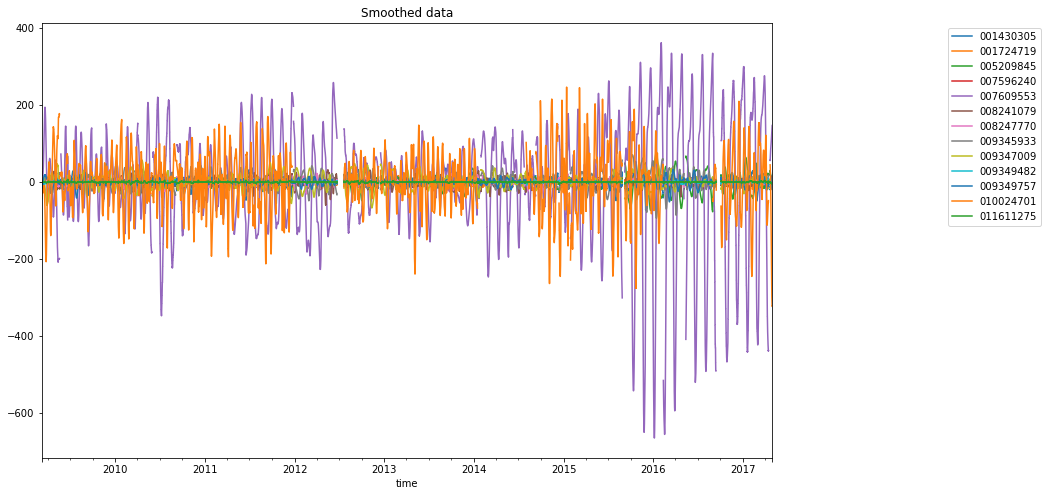

In [31]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 18, 8
fig, (ax, lax) = plt.subplots(ncols=2, gridspec_kw={"width_ratios": [4, 1]})
dataframe_mean.plot(ax=ax, title="Smoothed data")
ax.legend(bbox_to_anchor=(0, 0, 1, 1), bbox_transform=lax.transAxes)
lax.axis("off")

### Normalize data

<AxesSubplot:>

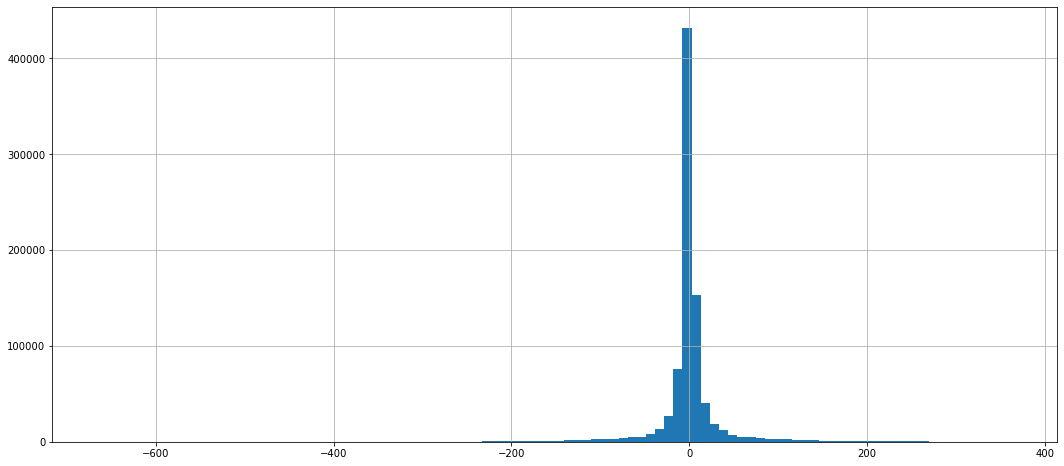

In [32]:
dataframe_mean.stack().hist(bins=100)

In [33]:
from wax.encode import Encoder


def min_max_scaler(values: pd.DataFrame, output_format: str = "dataframe") -> Encoder:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(values)
    index = values.index
    columns = values.columns

    def encode(dataframe: pd.DataFrame):
        nonlocal index
        nonlocal columns
        index = dataframe.index
        columns = dataframe.columns
        array_normed = scaler.transform(dataframe)
        if output_format == "dataframe":
            return pd.DataFrame(array_normed, index, columns)
        elif output_format == "jax":
            return jnp.array(array_normed)
        else:
            return array_normed

    def decode(array_scaled):
        value = scaler.inverse_transform(array_scaled)
        if output_format == "dataframe":
            return pd.DataFrame(value, index, columns)
        else:
            return value

    return Encoder(encode, decode)

In [34]:
scaler = min_max_scaler(dataframe_mean)
dataframe_normed = scaler.encode(dataframe_mean)
assert (scaler.decode(dataframe_normed) - dataframe_mean).stack().abs().max() < 1.0e-4

<AxesSubplot:>

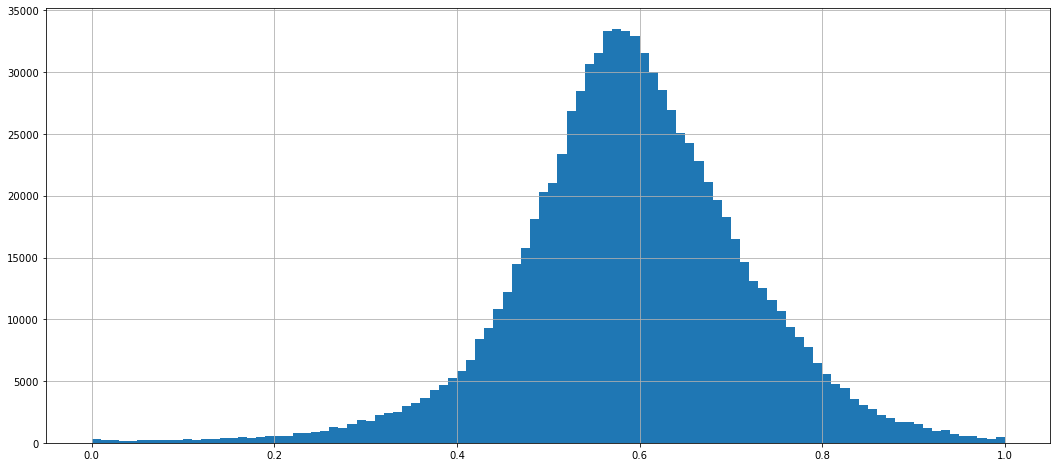

In [35]:
dataframe_normed.stack().hist(bins=100)

### Prepare train / validation datasets

In [36]:
from wax.modules import FillNanInf, Lag

In [37]:
def split_feature_target(dataframe, look_back=SEQ_LEN) -> Pair:
    x, _ = dataframe.wax.stream(format_outputs=False).apply(
        lambda x: FillNanInf()(Lag(1)(Buffer(look_back)(x)))
    )
    B, T, F = x.shape
    x = x.transpose(1, 0, 2)

    y, _ = dataframe.wax.stream(format_outputs=False).apply(
        lambda x: FillNanInf()(Buffer(look_back)(x))
    )
    y = y.transpose(1, 0, 2)
    return Pair(x, y)


def split_feature_target(
    dataframe,
    look_back=SEQ_LEN,
    stack=True,
    shuffle=False,
    min_periods_ratio: float = 0.8,
) -> Pair:
    x, _ = dataframe.wax.stream(format_outputs=False).apply(
        lambda x: Lag(1)(Buffer(look_back)(x))
    )
    x = x.transpose(1, 0, 2)

    y, _ = dataframe.wax.stream(format_outputs=False).apply(
        lambda x: Buffer(look_back)(x)
    )
    y = y.transpose(1, 0, 2)

    T, B, F = x.shape

    if stack:
        x = x.reshape(T, B * F, 1)
        y = y.reshape(T, B * F, 1)

    if shuffle:
        rng = jax.random.PRNGKey(42)
        idx = jnp.arange(x.shape[1])
        idx = jax.random.shuffle(rng, idx)
        x = x[:, idx]
        y = y[:, idx]

    if min_periods_ratio:
        count_nan = jnp.isnan(x).sum(axis=0)
        mask = count_nan < min_periods_ratio * T
        idx = jnp.where(mask)
        # print("count_nan = ", count_nan)
        # print("B = ", B)
        x = x[:, idx[0], :]
        y = y[:, idx[0], :]
        T, B, F = x.shape
        # print("B = ", B)

    # round Batch size to a power of to
    B_round = int(2 ** jnp.floor(jnp.log2(B)))
    x = x[:, :B_round, :]
    y = y[:, :B_round, :]

    # fillnan by zeros
    fill_nan_inf = hk.transform(lambda x: FillNanInf()(x))
    params = fill_nan_inf.init(None, jnp.full(x.shape, jnp.nan, x.dtype))
    x = fill_nan_inf.apply(params, None, x)
    y = fill_nan_inf.apply(params, None, y)

    return Pair(x, y)

In [38]:
def split_train_validation(dataframe, stars, train_size, look_back) -> TrainSplit:

    # prepare scaler
    dataframe_train = dataframe[stars].iloc[:train_size]
    scaler = min_max_scaler(dataframe_train)

    # prepare train data
    dataframe_train_normed = scaler.encode(dataframe_train)
    train = split_feature_target(dataframe_train_normed, look_back)

    # prepare validation data
    valid_size = len(dataframe[stars]) - train_size
    valid_size = int(2 ** jnp.floor(jnp.log2(valid_size)))
    valid_end = int(train_size + valid_size)
    dataframe_valid = dataframe[stars].iloc[train_size:valid_end]
    dataframe_valid_normed = scaler.encode(dataframe_valid)
    valid = split_feature_target(dataframe_valid_normed, look_back)

    return TrainSplit(train, valid)

In [39]:
print(f"Look at star: {STAR}")
train, valid = split_train_validation(dataframe_normed, [STAR], TRAIN_SIZE, SEQ_LEN)

Look at star: 007609553


In [40]:
train[0].shape, train[1].shape, valid[0].shape, valid[1].shape

((64, 32768, 1), (64, 32768, 1), (64, 2048, 1), (64, 2048, 1))

In [41]:
TRAIN_SIZE, VALID_SIZE = len(train.x), len(valid.x)

In [42]:
seq = hk.PRNGSequence(42)

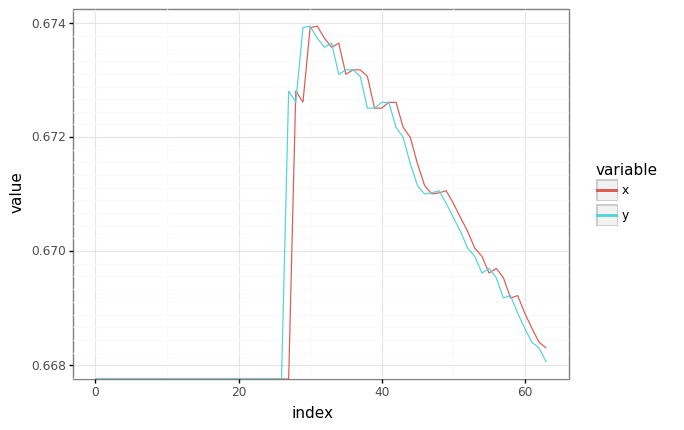

In [43]:
# Plot an observation/target pair.
batch_plot = jax.random.choice(next(seq), len(train[0]))
df = pd.DataFrame(
    {"x": train[0][:, batch_plot, 0], "y": train[1][:, batch_plot, 0]}
).reset_index()
df = pd.melt(df, id_vars=["index"], value_vars=["x", "y"])
plot = (
    gg.ggplot(df)
    + gg.aes(x="index", y="value", color="variable")
    + gg.geom_line()
    + gg.scales.scale_y_log10()
)
_ = plot.draw()

### Dataset iterator

In [44]:
class Dataset:
    """An iterator over a numpy array, revealing batch_size elements at a time."""

    def __init__(self, xy: Pair, batch_size: int):
        self._x, self._y = xy
        self._batch_size = batch_size
        self._length = self._x.shape[1]
        self._idx = 0
        if self._length % batch_size != 0:
            msg = "dataset size {} must be divisible by batch_size {}."
            raise ValueError(msg.format(self._length, batch_size))

    def __next__(self) -> Pair:
        start = self._idx
        end = start + self._batch_size
        x, y = self._x[:, start:end], self._y[:, start:end]
        if end >= self._length:
            end = end % self._length
            assert end == 0  # Guaranteed by ctor assertion.
        self._idx = end
        return x, y

In [45]:
train_ds = Dataset(train, BATCH_SIZE)
valid_ds = Dataset(valid, BATCH_SIZE)
del train, valid  # Don't leak temporaries.

### Training an LSTM

To train the LSTM, we define a Haiku function which unrolls the LSTM over the input sequence, generating predictions for all output values. The LSTM always starts with its initial state at the start of the sequence.

The Haiku function is then transformed into a pure function through `hk.transform`, and is trained with Adam on an L2 prediction loss.

In [46]:
from wax.compile import jit_init_apply

In [47]:
x, y = next(train_ds)
x.shape, y.shape

((64, 8, 1), (64, 8, 1))

In [48]:
from collections import defaultdict

In [49]:
def unroll_net(seqs: jnp.ndarray):
    """Unrolls an LSTM over seqs, mapping each output to a scalar."""
    # seqs is [T, B, F].
    core = hk.LSTM(32)
    batch_size = seqs.shape[1]
    outs, state = hk.dynamic_unroll(core, seqs, core.initial_state(batch_size))
    # We could include this Linear as part of the recurrent core!
    # However, it's more efficient on modern accelerators to run the linear once
    # over the entire sequence than once per sequence element.
    return hk.BatchApply(hk.Linear(1))(outs), state

In [50]:
model = jit_init_apply(hk.transform(unroll_net))

In [51]:
def train_model(
    train_ds: Dataset, valid_ds: Dataset, max_iterations: int = -1
) -> hk.Params:
    """Initializes and trains a model on train_ds, returning the final params."""
    rng = jax.random.PRNGKey(428)
    opt = optax.adam(1e-3)

    @jax.jit
    def loss(params, x, y):
        pred, _ = model.apply(params, None, x)
        return jnp.mean(jnp.square(pred - y))

    @jax.jit
    def update(step, params, opt_state, x, y):
        l, grads = jax.value_and_grad(loss)(params, x, y)
        grads, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, grads)
        return l, params, opt_state

    # Initialize state.
    sample_x, _ = next(train_ds)
    params = model.init(rng, sample_x)
    opt_state = opt.init(params)

    step = 0
    records = defaultdict(list)

    def _format_results(records):
        records = {key: jnp.stack(l) for key, l in records.items()}
        return records

    with tqdm() as pbar:
        while True:
            if step % 100 == 0:
                x, y = next(valid_ds)
                valid_loss = loss(params, x, y)
                # print("Step {}: valid loss {}".format(step, valid_loss))
                records["step"].append(step)
                records["valid_loss"].append(valid_loss)

            try:
                x, y = next(train_ds)
            except StopIteration:
                return params, _format_results(records)
            train_loss, params, opt_state = update(step, params, opt_state, x, y)
            if step % 100 == 0:
                # print("Step {}: train loss {}".format(step, train_loss))
                records["train_loss"].append(train_loss)

            step += 1
            pbar.update()
            if max_iterations > 0 and step >= max_iterations:
                return params, _format_results(records)

In [52]:
%%time
trained_params, records = train_model(train_ds, valid_ds, TRAIN_STEPS)

0it [00:00, ?it/s]

CPU times: user 2min 36s, sys: 6.9 s, total: 2min 42s
Wall time: 1min 23s


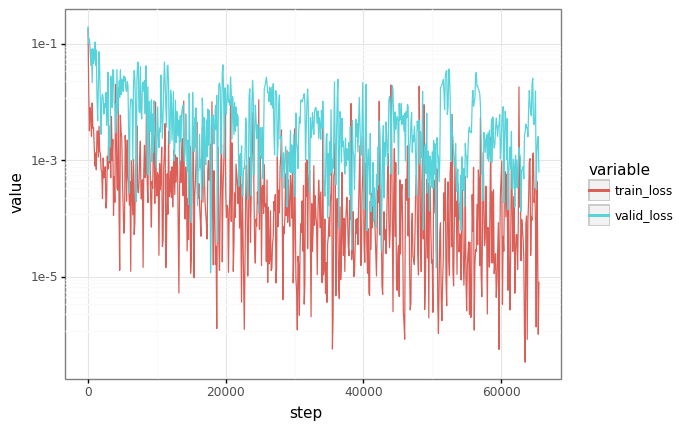

In [53]:
# Plot losses
losses = pd.DataFrame(records)
df = pd.melt(losses, id_vars=["step"], value_vars=["train_loss", "valid_loss"])
plot = (
    gg.ggplot(df)
    + gg.aes(x="step", y="value", color="variable")
    + gg.geom_line()
    + gg.scales.scale_y_log10()
)
_ = plot.draw()

### Sampling

The point of training models is so that they can make predictions! How can we generate predictions with the trained model?

If we're allowed to feed in the ground truth, we can just run the original model's `apply` function.

In [54]:
def plot_samples(truth: np.ndarray, prediction: np.ndarray) -> gg.ggplot:
    assert truth.shape == prediction.shape
    df = pd.DataFrame(
        {"truth": truth.squeeze(), "predicted": prediction.squeeze()}
    ).reset_index()
    df = pd.melt(df, id_vars=["index"], value_vars=["truth", "predicted"])
    plot = (
        gg.ggplot(df) + gg.aes(x="index", y="value", color="variable") + gg.geom_line()
    )
    return plot

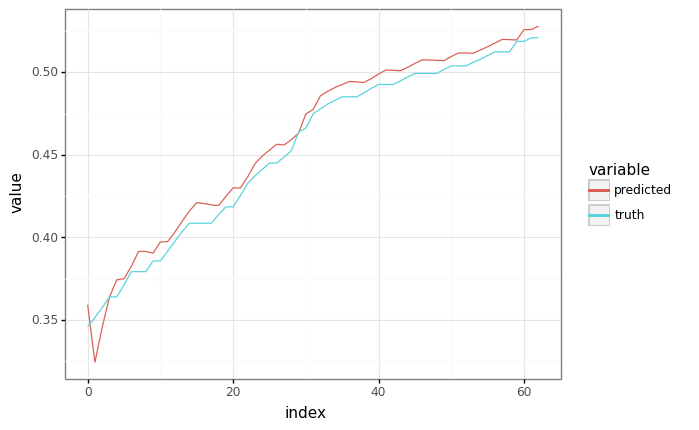

In [55]:
# Grab a sample from the validation set.
sample_x, _ = next(valid_ds)
sample_x = sample_x[:, :1]  # Shrink to batch-size 1.

# Generate a prediction, feeding in ground truth at each point as input.
predicted, _ = model.apply(trained_params, None, sample_x)

plot = plot_samples(sample_x[1:], predicted[:-1])
plot.draw()
del sample_x, predicted

### Run autoregressively

If we can't feed in the ground truth (because we don't have it), we can also run the model autoregressively.

In [56]:
def autoregressive_predict(
    trained_params: hk.Params,
    context: jnp.ndarray,
    seq_len: int,
):
    """Given a context, autoregressively generate the rest of a sine wave."""
    ar_outs = []
    context = jax.device_put(context)
    times = range(seq_len - context.shape[0])
    for _ in times:
        full_context = jnp.concatenate([context] + ar_outs)
        outs, _ = jax.jit(model.apply)(trained_params, None, full_context)
        # Append the newest prediction to ar_outs.
        ar_outs.append(outs[-1:])
    # Return the final full prediction.
    return outs

In [57]:
sample_x, _ = next(valid_ds)
context_length = SEQ_LEN // 8
# Cut the batch-size 1 context from the start of the sequence.
context = sample_x[:context_length, :1]

CPU times: user 9.71 s, sys: 194 ms, total: 9.91 s
Wall time: 9.82 s


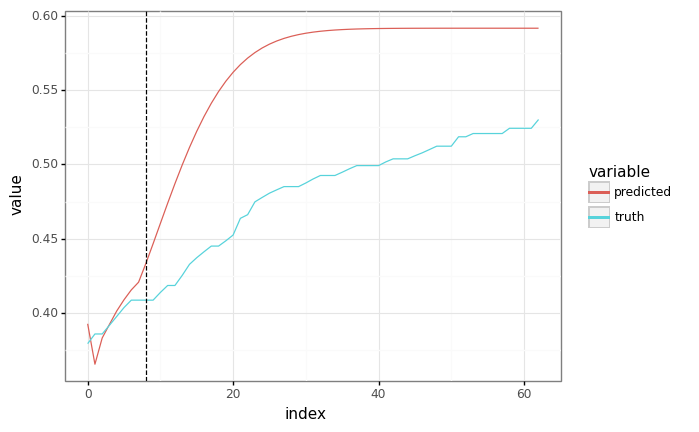

In [58]:
%%time
# We can reuse params we got from training for inference - as long as the
# declaration order is the same.
predicted = autoregressive_predict(trained_params, context, SEQ_LEN)

plot = plot_samples(sample_x[1:, :1], predicted)
plot += gg.geom_vline(xintercept=len(context), linetype="dashed")
plot.draw()
del predicted

#### Sharing parameters with a different function.

Unfortunately, this is a bit slow - we're doing O(N^2) computation for a sequence of length N.

It'd be better if we could do the autoregressive sampling all at once - but we need to write a new Haiku function for that.

We're in luck - if the Haiku module names match, the same parameters can be used for multiple Haiku functions.

This can be achieved through a combination of two techniques:

1. If we manually give a unique name to a module, we can ensure that the parameters are directed to the right places.
2. If modules are instantiated in the same order, they'll have the same names in different functions.

Here, we rely on method #2 to create a fast autoregressive prediction.

In [59]:
def fast_autoregressive_predict_fn(context, seq_len):
    """Given a context, autoregressively generate the rest of a sine wave."""
    core = hk.LSTM(32)
    dense = hk.Linear(1)
    state = core.initial_state(context.shape[1])
    # Unroll over the context using `hk.dynamic_unroll`.
    # As before, we `hk.BatchApply` the Linear for efficiency.
    context_outs, state = hk.dynamic_unroll(core, context, state)
    context_outs = hk.BatchApply(dense)(context_outs)

    # Now, unroll one step at a time using the running recurrent state.
    ar_outs = []
    x = context_outs[-1]
    times = range(seq_len - context.shape[0])
    for _ in times:
        x, state = core(x, state)
        x = dense(x)
        ar_outs.append(x)
    return jnp.concatenate([context_outs, jnp.stack(ar_outs)])


fast_ar_predict = hk.transform(fast_autoregressive_predict_fn)
fast_ar_predict = jax.jit(fast_ar_predict.apply, static_argnums=3)

CPU times: user 6.67 s, sys: 144 ms, total: 6.82 s
Wall time: 6.75 s


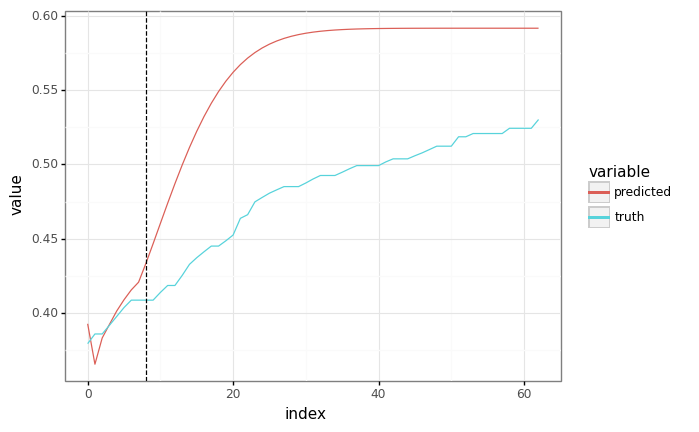

In [60]:
%%time
# Reuse the same context from the previous cell.
predicted = fast_ar_predict(trained_params, None, context, SEQ_LEN)

# The plots should be equivalent!
plot = plot_samples(sample_x[1:, :1], predicted[:-1])
plot += gg.geom_vline(xintercept=len(context), linetype="dashed")
_ = plot.draw()

In [61]:
%timeit autoregressive_predict(trained_params, context, SEQ_LEN)
%timeit fast_ar_predict(trained_params, None, context, SEQ_LEN)

86.3 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.2 µs ± 549 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Train all stars

### Training

In [62]:
def split_train_validation_date(dataframe, stars, date, look_back) -> TrainSplit:
    train_size = len(dataframe.loc[:date])
    return split_train_validation(dataframe, stars, train_size, look_back)

In [63]:
%%time
train, valid = split_train_validation_date(dataframe_normed, stars, TRAIN_DATE, SEQ_LEN)
TRAIN_SIZE = train[0].shape[1]
print(f"TRAIN_SIZE = {TRAIN_SIZE}")

TRAIN_SIZE = 524288
CPU times: user 5.45 s, sys: 1.75 s, total: 7.2 s
Wall time: 4.42 s


In [64]:
train[0].shape, train[1].shape, valid[0].shape, valid[1].shape

((64, 524288, 1), (64, 524288, 1), (64, 16384, 1), (64, 16384, 1))

In [65]:
train_ds = Dataset(train, BATCH_SIZE)
valid_ds = Dataset(valid, BATCH_SIZE)
del train, valid  # Don't leak temporaries.

In [66]:
%%time
trained_params, records = train_model(train_ds, valid_ds, TRAIN_STEPS)

0it [00:00, ?it/s]

CPU times: user 2min 36s, sys: 7.03 s, total: 2min 43s
Wall time: 1min 24s


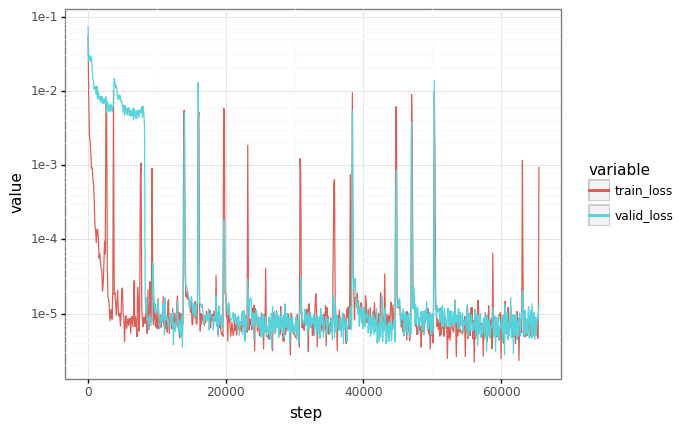

In [67]:
# Plot losses
losses = pd.DataFrame(records)
df = pd.melt(losses, id_vars=["step"], value_vars=["train_loss", "valid_loss"])
plot = (
    gg.ggplot(df)
    + gg.aes(x="step", y="value", color="variable")
    + gg.geom_line()
    + gg.scales.scale_y_log10()
)
_ = plot.draw()

### Sampling

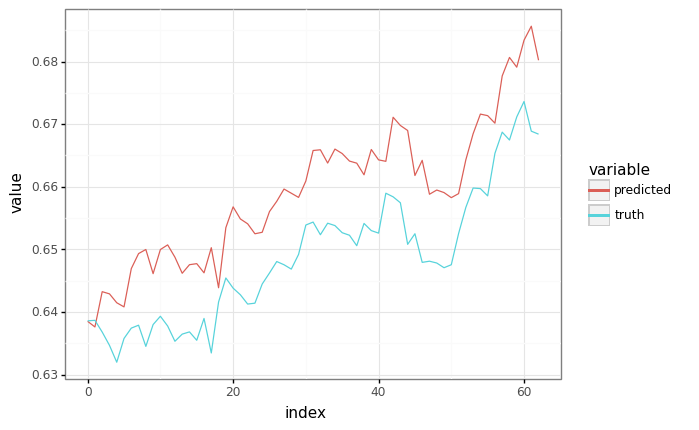

In [68]:
# Grab a sample from the validation set.
sample_x, _ = next(valid_ds)
sample_x = sample_x[:, :1]  # Shrink to batch-size 1.

# Generate a prediction, feeding in ground truth at each point as input.
predicted, _ = model.apply(trained_params, None, sample_x)

plot = plot_samples(sample_x[1:], predicted[:-1])
plot.draw()
del sample_x, predicted

### Run autoregressively

CPU times: user 195 ms, sys: 18.2 ms, total: 213 ms
Wall time: 144 ms


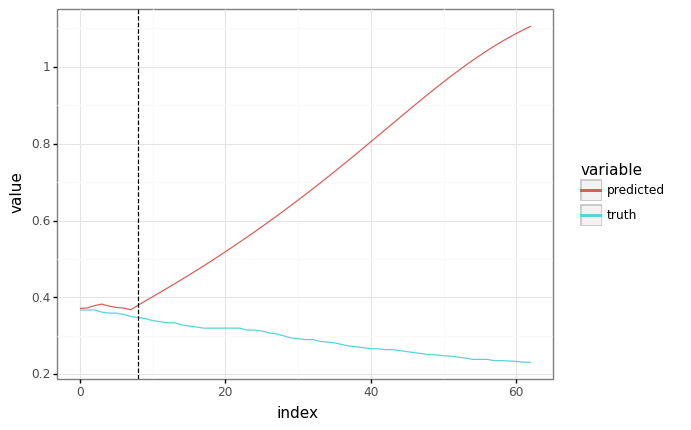

In [69]:
%%time
sample_x, _ = next(valid_ds)
context_length = SEQ_LEN // 8
# Cut the batch-size 1 context from the start of the sequence.
context = sample_x[:context_length, :1]

# Reuse the same context from the previous cell.
predicted = fast_ar_predict(trained_params, None, context, SEQ_LEN)

# The plots should be equivalent!
plot = plot_samples(sample_x[1:, :1], predicted[:-1])
plot += gg.geom_vline(xintercept=len(context), linetype="dashed")
_ = plot.draw()